In [1]:
# Imports
import torch
torch.cuda.empty_cache()

import hr_dv2.transform as tr
from hr_dv2.utils import *
import numpy as np
from PIL import Image
from sklearn.decomposition import PCA, NMF, MiniBatchNMF
import matplotlib.pyplot as plt
from itertools import permutations
from math import floor, ceil, sqrt

from typing import Tuple, List, Any, TypedDict

IMG_SIZE = 490
PATCH_SIZE  = 14
PATCH_H, PATCH_W = IMG_SIZE // PATCH_SIZE, IMG_SIZE // PATCH_SIZE
FEAT_DIM = 384

transform = tr.get_input_transform(490, IMG_SIZE)

In [2]:
from hr_dv2 import HighResDV2

net = HighResDV2("dinov2_vits14_reg", 4, dtype=torch.float16)
net.cuda()
net.eval()
pass

Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dinov2_main
/home/ronan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/ronan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/ronan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


This is the image used in ['Vision Transformers Need Registers'](https://arxiv.org/abs/2309.16588) for attention visualization, so I've reused it here. I couldn't find the original source so have just cropped from the paper.

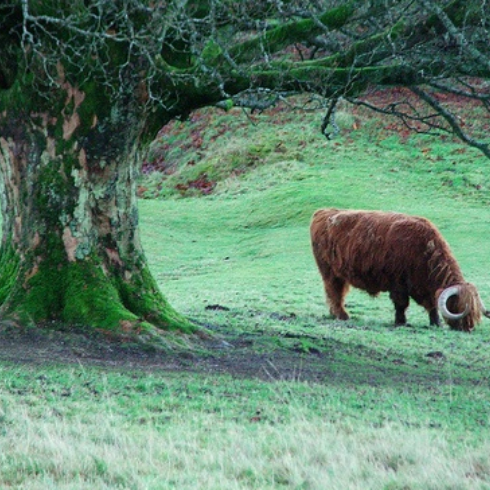

In [3]:
tensor, img = tr.load_image("data/v5.png", transform)
tensor.to(torch.float16)
tensor = tensor.cuda()
img

We run the high-res model at stride 4 with 1, 2 pixel shifts and save the attention maps of the CLS token. The CLS token is a global descriptor of the image (used later in downstream tasks like classification). The attention map is the values at each of the N attention heads of the last layer of the network for the CLS token with every spatial token.

In [4]:
shift_dists = [i for i in range(1, 3)]
transforms, inv_transforms = tr.get_shift_transforms(shift_dists, 'Moore')
net.set_transforms(transforms, inv_transforms)
# run sequentially or we get OOM in attention calculation
cls_attn, _ = net.forward_sequential(tensor, attn="cls")
cls_attn = tr.to_numpy(cls_attn)

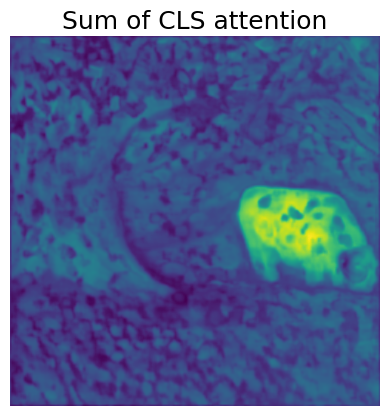

In [5]:
plt.imshow(np.sum(cls_attn, axis=0))
plt.title("Sum of CLS attention", fontsize=18)
plt.gca().set_axis_off()

In the paper, they found self-supervised ViTs were using irrelevant (i.e background) feature tokens to store information causing artefacts in the features and attention. They fixed this by including ~4 register tokens that are discarded at the end of the forward pass but exist for the network to store information during the forward pass. They showed this fixed the artefacting, and also showed they appeared to contain information about distinct objects in the image. We plot these attention maps of the register tokens here in high-resolution. We see similar reuslts to theirs, and see decomposition of the image into objects like sugar cubes, spoon, coffee, the mug *etc.*

In [6]:
attn, _ = net.forward_sequential(tensor, attn="both")
attn = tr.to_numpy(attn)

(30, 490, 490)


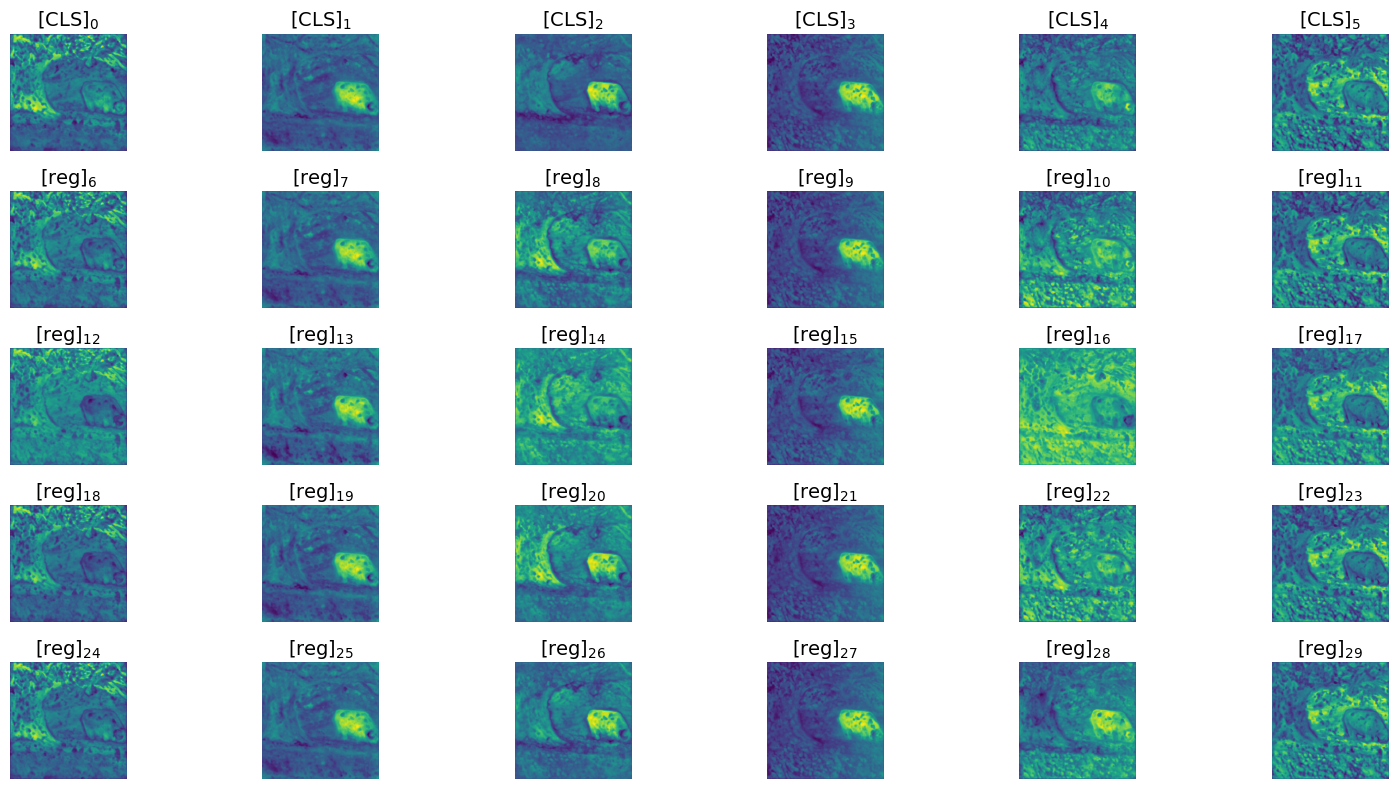

In [7]:
print(attn.shape)
N_COLS, N_ROWS = 6, 5
fig, axs = plt.subplots(nrows=N_ROWS, ncols=N_COLS)
fig.set_size_inches(16, 8)

for i in range(N_COLS * N_ROWS):
    reg_i = attn[i, :, :]
    ax = axs[i // N_COLS, i % N_COLS]
    ax.imshow(reg_i)
    ax.set_axis_off()
    if i < N_COLS:
        title = "$[\\text{CLS}]_{"+str(i)+"}$"
    else:
        title = "$[\\text{reg}]_{"+str(i)+"}$"
    ax.set_title(title, fontsize=14)
plt.tight_layout()

(30, 490, 490)
uint8 251


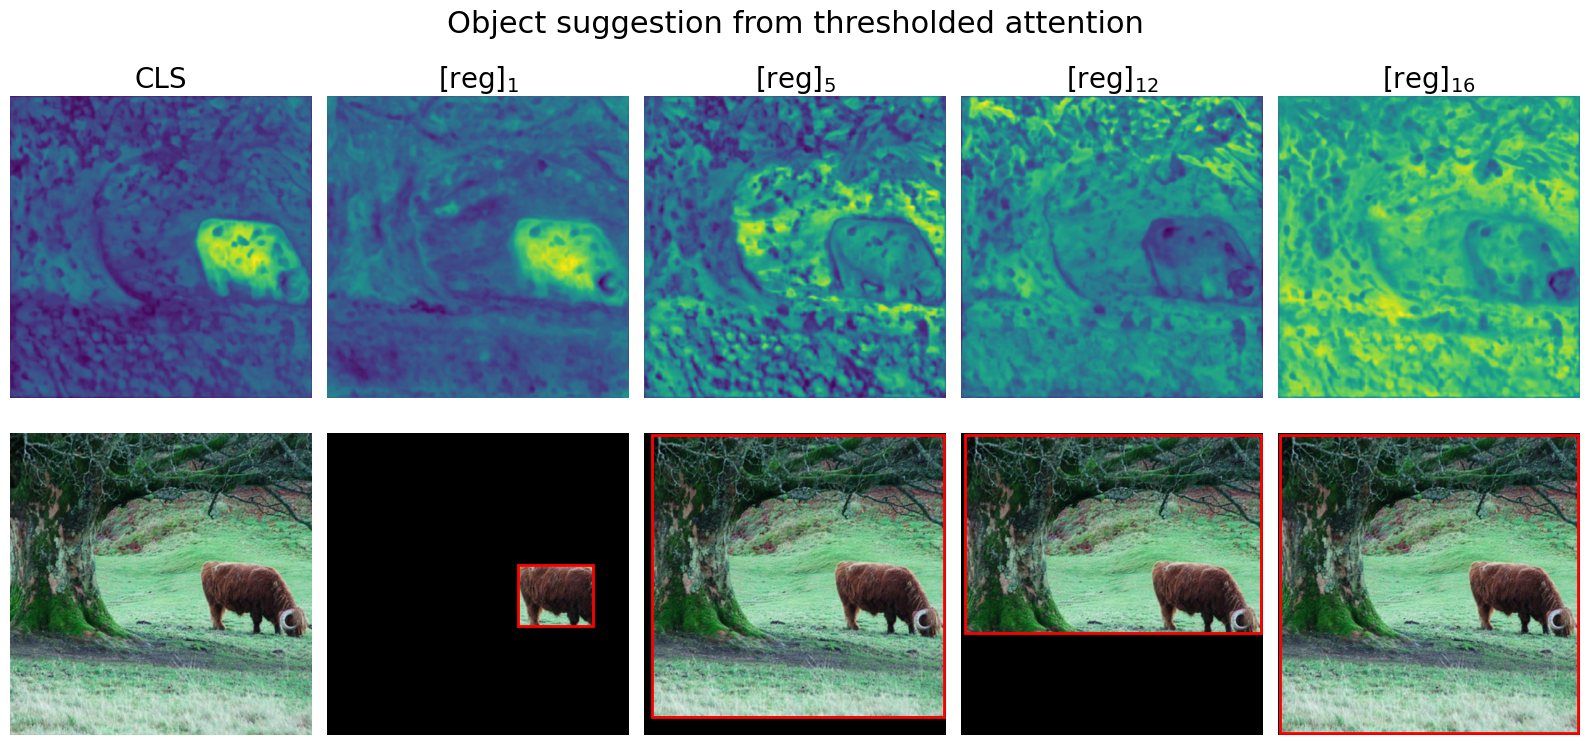

In [8]:
import matplotlib.patches as patches
print(attn.shape)
fig, axs = plt.subplots(nrows=2, ncols=5)
fig.set_size_inches(16, 8)

h, w = attn.shape[1:]
img_arr = np.array(img)
print(img_arr.dtype, np.amax(img_arr))

fig.suptitle("Object suggestion from thresholded attention", fontsize=22)
axs[0, 0].imshow(np.sum(cls_attn, axis=0))
axs[1, 0].imshow(img)

axs[0, 0].set_axis_off()
axs[1, 0].set_axis_off()
title = "CLS"
axs[0, 0].set_title(title, fontsize=20)

for j, i in enumerate([1, 5, 12, 16]):
    reg_i = attn[i, :, :]
    #threshold = threshold_multiotsu(reg_i, 2)
    ax_1 = axs[0, j + 1]
    ax_2 = axs[1, j + 1]
    #ax.imshow(reg_i > threshold[0])
    flat = reg_i.flatten().astype(np.float64)
    
    filtered = reg_i > 0.7 * np.amax(flat)
    idxs = np.nonzero(filtered)
    min_y, max_y = np.amin(idxs[0]), np.amax(idxs[0])
    min_x, max_x = np.amin(idxs[1]), np.amax(idxs[1])
    
    rect = patches.Rectangle((min_x, min_y), max_x - min_x,  max_y - min_y,linewidth=2, edgecolor='r', facecolor='none' )
    
    mask = np.zeros((h, w, 1), dtype=np.uint8)
    mask[min_y:max_y, min_x:max_x, :] = 1
    ax_1.imshow(reg_i)
    ax_2.imshow(img_arr * mask)
    ax_2.add_patch(rect)

    ax_1.set_axis_off()
    ax_2.set_axis_off()
    title = "$[\\text{reg}]_{"+str(i)+"}$"
    ax_1.set_title(title, fontsize=20)
plt.tight_layout()

In [9]:
from skimage.metrics import structural_similarity as ssim

def get_diffs(attn_maps: np.ndarray) -> np.ndarray:
    N, h, w = attn_maps.shape
    idxs = [i for i in range(N)]
    pairs = list(permutations(idxs, r=2))
    N_diffs = len(pairs)
    diff_arr = np.zeros((N_diffs, h, w))
    arr_idx = 0
    for i, j in pairs:
        diff_arr[arr_idx, :, :] = attn_maps[i, :, :] - attn_maps[j, :, :]
        arr_idx += 1
    return diff_arr

def get_similarities(attn_maps: np.ndarray) -> List[float]:
    similarities: List[float] = []
    N, h, w = attn_maps.shape
    idxs = [i for i in range(N)]
    pairs = list(permutations(idxs, r=2))
    area = h * w
    for i, j in pairs:
        #print(attn_maps[i, :, :].shape)
        delta = np.sum(np.abs(attn_maps[i, :, :] - attn_maps[j, :, :]))
        #print(delta)
        similarities.append(delta)
    return similarities


def merge_similar_maps(attn_maps: np.ndarray, threshold: float, similarities: List[float]) -> Tuple[np.ndarray, List[int]]:
    N, h, w = attn_maps.shape
    tril = np.tri(N, N, -1)
    np.place(tril, tril, np.array(similarities))
    sim_matrix = tril 
    to_merge =  (sim_matrix < threshold) * (sim_matrix > 0)

    is_merged = np.array([False for i in range(N)])
    merged: List[np.ndarray] = []
    votes: List[int] = []
    for i in range(N):
        flag = is_merged[i]
        if flag == False:
            new_map = np.zeros((h, w))
            to_merge =  (sim_matrix[:, i] < threshold) * (sim_matrix[:, i] > 0)
            merge_idxs = np.nonzero(to_merge)[0]
            merge_idxs = np.concatenate((merge_idxs, [i]))
            new_map = np.mean(attn_maps[merge_idxs, :, :], axis=0)
            is_merged[merge_idxs] = True
            #sim_matrix[:, merge_idxs] = -1
            #triu[:, merge_idxs] = -1
            merged.append(new_map)
            votes.append(len(merge_idxs))
    print(len(merged))
    return np.stack(merged), votes


def merge(attn_maps: np.ndarray, threshold: float, n_iters=2) -> np.ndarray:
    for i in range(n_iters):
        sims = get_similarities(attn_maps)
        attn_maps, votes = merge_similar_maps(attn_maps, threshold, sims)
        print(votes)
    return attn_maps    

def plot_grid(attn_maps: np.ndarray) -> None:
    N = attn_maps.shape[0]
    N_ROWS = floor(sqrt(N))
    N_COLS = ceil(N / N_ROWS)
    fig, axs = plt.subplots(nrows=N_ROWS, ncols=N_COLS)
    fig.set_size_inches(16, 16)
    for i, attn_map in enumerate(attn_maps):
        ax = axs[i // N_COLS, i % N_COLS]
        ax.imshow(attn_map)
        ax.set_axis_off()

In [10]:
from scipy.linalg import norm
from skimage.filters import gaussian
from skimage.filters.rank import mean
from skimage.morphology import disk
from scipy.special import softmax


print(np.amax(attn[3]))
attn = attn.astype(np.float32)
norm_attn = np.zeros_like(attn, dtype=np.float32)
for i, c in enumerate(attn):
    #norm_attn[i, :, :] = c / np.sum(np.abs(c)) #L1 c / np.sum(np.abs(c))
    #norm_attn[i, :, :] = softmax(c)
    #norm_attn[i, :, :] = c
    norm_attn[i, :, :] = (c - np.amin(c)) / (np.amax(c) - np.amin(c))

18.23


In [31]:
N, h, w = norm_attn.shape
reshaped = norm_attn.reshape(N, h * w).T
nmf = NMF(n_components=7)
data = nmf.fit_transform(reshaped)


/home/ronan/Documents/uni_work/phd/hr_dv2/.venv/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


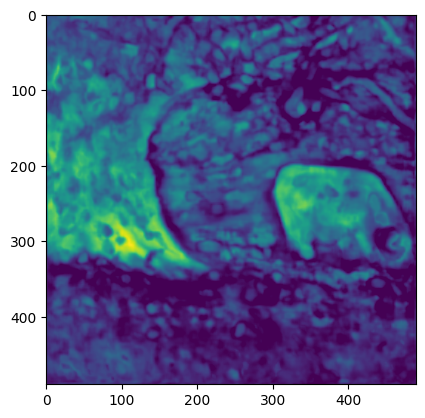

In [39]:
data2D = data.reshape((ih, iw, 7))
plt.imshow(data2D[:, :, 6])
fig

In [40]:
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_softmax

LABEL_CONFIDENCE = 0.7
SXY_G, SXY_B = (3, 3), (40, 40)
SRGB = (13, 13, 13)
COMPAT_G, COMPAT_B = 10, 10
KERNEL = dcrf.DIAG_KERNEL

segs = []
for i, n in enumerate(data2D.transpose(2, 0, 1)):
    ih, iw = n.shape
    p1 = n.reshape(ih * iw)
    p2 = 1 - p1
    prob = np.stack((p1, p2))
    prob = np.reshape(prob, (2, ih * iw))
    unary = -1 * np.log(prob + 1e-7) #-1 * np.log(prob)
    d = dcrf.DenseCRF2D(iw, ih, 2)
    u = np.ascontiguousarray(unary)
    d.setUnaryEnergy(u)
    d.addPairwiseGaussian(sxy=SXY_G, compat=COMPAT_G, kernel=KERNEL,
                        normalization=dcrf.NORMALIZE_SYMMETRIC)
    d.addPairwiseBilateral(sxy=SXY_B, srgb=SRGB, rgbim=img_arr, compat=COMPAT_B, kernel=KERNEL,
                            normalization=dcrf.NORMALIZE_SYMMETRIC)
    Q = d.inference(10)
    crf_seg = np.argmax(Q, axis=0)
    print(np.sum(crf_seg))
    crf_seg = crf_seg.reshape((ih, iw, 1)).astype(np.uint8)
    segs.append( (1 - crf_seg) * img_arr )

240100
240100
240100
240100
240100
240100
240100


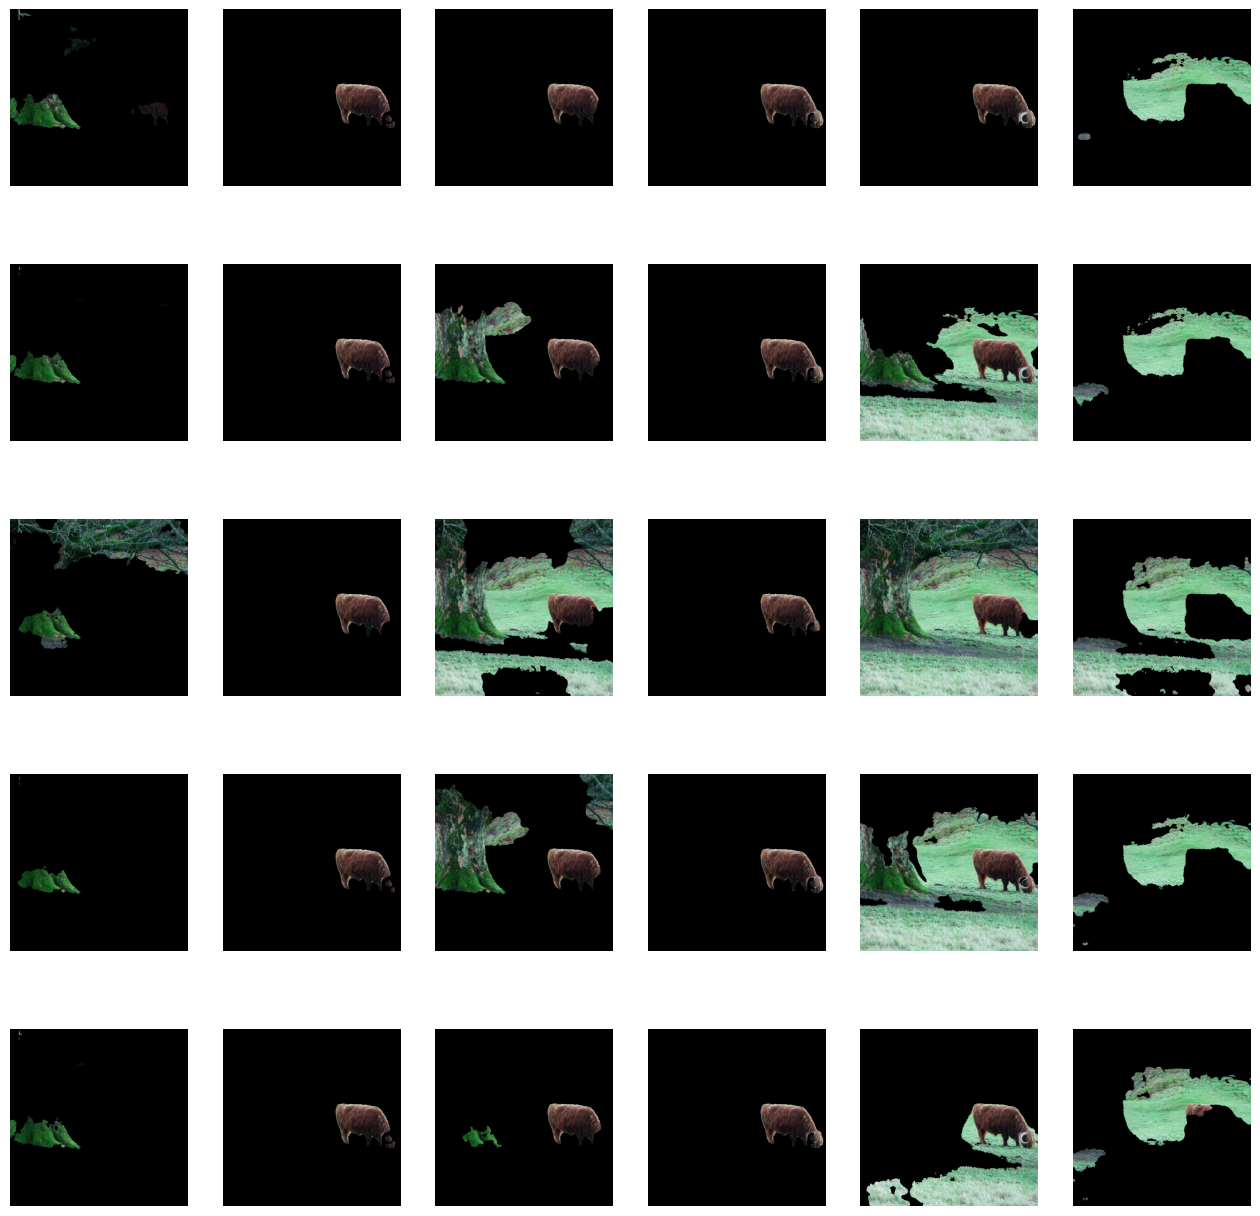

In [23]:
#print(segs.shape)
plot_grid(np.stack(segs))